## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf

## Exploring Raw Data

### Plotting some images 🦠

In [35]:
RAW_DATA_PATH = '../data/full/TEM virus dataset/context_virus_RAW'
IMAGE_SIZE = 256
viruses = os.listdir(os.path.join(RAW_DATA_PATH, 'train'))

In [74]:
#load the first image from a virus folder in train
def load_sample(virus):
    
    #get path to image 
    path = os.path.join(RAW_DATA_PATH, 'train', virus)
    files = os.listdir(path)
    selected_image_file = files[0]
    print(selected_image_file)
    selected_image = os.path.join(RAW_DATA_PATH,'train',virus,selected_image_file)
    img = cv2.imread(selected_image, -1)
    
    #get path to positions of viruses
    position_file_name = f'{selected_image_file[:selected_image_file.index(".")]}_particlepositions.txt'
    position_path = os.path.join(RAW_DATA_PATH, 
                             'train', 
                             virus, 
                             "particle_positions", 
                             position_file_name,
                             )
    
    #reading positions
    with open(position_path) as f:
        contents = f.readlines()
        
    particles = []
    for i, c in enumerate(contents):
        #it is a particle position
        if c[0].isdigit() and i>1:
            particles.append(tuple(int(d) for d in c.strip('\n').split(";")))
            
 
    return img, particles

B2-65k-070913_11.tif


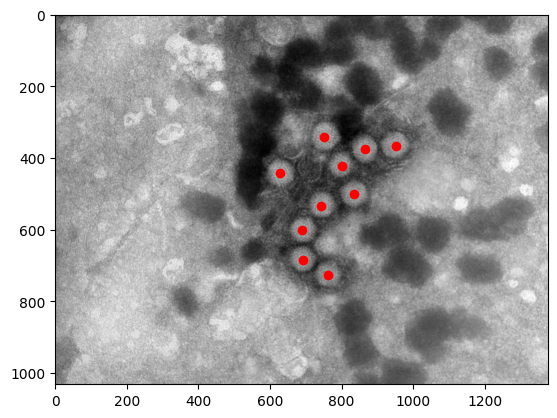

In [75]:
#plot labels and bounding box
img, positions = load_sample('Adenovirus')

plt.imshow(img, cmap="gray")
plt.scatter(x = [p[0] for p in positions], y = [p[1] for p in positions], c='r')

## Preprocessing steps

### Lanczos3 Kernel interpolation to rescale images to same pixel size

Our goal is to make sure the resolution of all images is 1px = 1nm. We therefore need to zoom or dezoom each image to achieve that resolutions

We will use Laczos 3 kernel interpolation for that purpose

In [102]:
#get an image to test
dataset = "train"
virus = "Adenovirus"
image_file = "A4-65k-071120_2"

#get the path to all the files
image_path = os.path.join(RAW_DATA_PATH, dataset, virus, f'{image_file}.tif')
position_path = os.path.join(RAW_DATA_PATH, dataset, virus, "particle_positions", f'{image_file}_particlepositions.txt')
tag_path = os.path.join(RAW_DATA_PATH, dataset, virus, "tags", f'{image_file}.tif_tags.csv')

#get the image
img = np.expand_dims(cv2.imread(image_path, -1).astype(np.float32),2)
# img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


#get a dict with tag
tag_dict = {}
with open(tag_path) as f:
    for l in f.readlines():
        values = l.split(";")
        tag_dict[values[0]] = values[1].strip('\n')


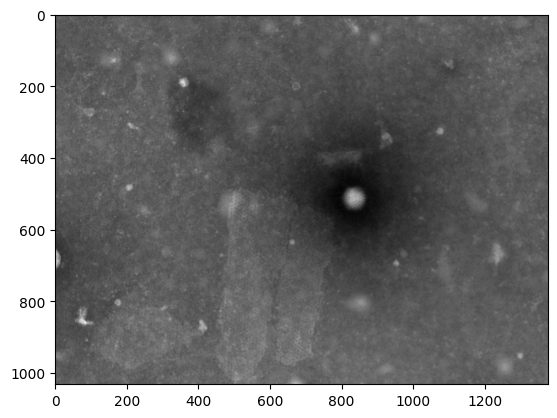

In [104]:
#show base image
plt.imshow(img, cmap="gray")

In [105]:
new_width = round(int(tag_dict['Heigt'])*float(tag_dict['Yscale'].replace(',','.')))
new_height = round(int(tag_dict['Width'])*float(tag_dict['Xscale'].replace(',','.')))

resized_img = tf.image.resize(
    img,
    size = (new_width,new_height),
    method  = tf.image.ResizeMethod.LANCZOS3
)

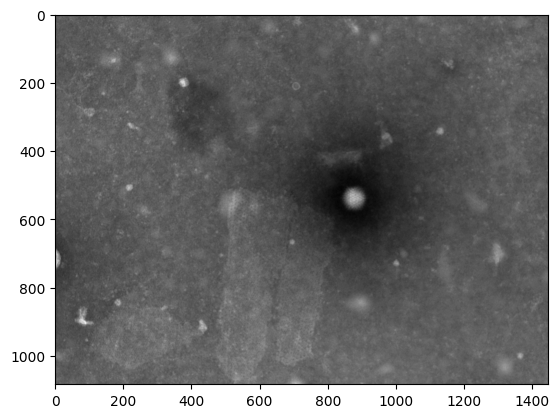

In [106]:
plt.imshow(resized_img, cmap="gray");

We need to apply the same transformation to the particle positions

In [107]:
particles = []

with open(position_path) as f:
    for i, l in enumerate(f.readlines()):
        if l[0].isdigit() and i>1:
            particles.append(tuple(int(d) for d in l.strip('\n').split(";")))

In [108]:
particles

[(835, 514)]

In [109]:
#apply the transformation to the particle coordinates as well
for i in range(len(particles)):
    particles[i] = (particles[i][0]*float(tag_dict['Yscale'].replace(',','.')), 
                    particles[i][1]*float(tag_dict['Xscale'].replace(',','.')))

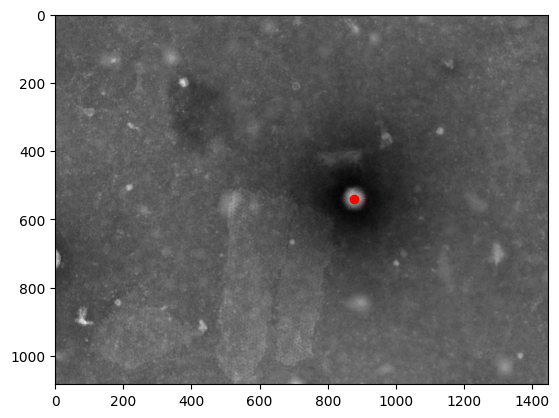

In [110]:
#show images
plt.imshow(resized_img, cmap="gray")
plt.scatter(x = [p[0] for p in particles], y = [p[1] for p in particles], c='r')

### Min max scaling

We need to min max scale all picture data

In [111]:
scaled_resized_img = cv2.normalize(resized_img.numpy(),None, 1.0,0.0,cv2.NORM_MINMAX)

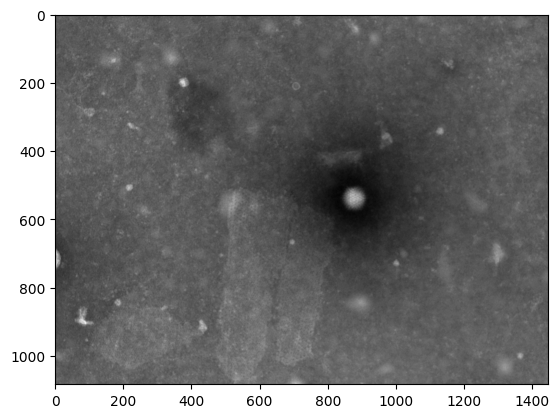

In [112]:
plt.imshow(scaled_resized_img, cmap="gray")

### Add padding 

This is optionnal, let's keep track of when we have issues and see if we really need to add padding

In [113]:
padded_img = cv2.copyMakeBorder(scaled_resized_img, IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE, cv2.BORDER_REFLECT)

padded_scaled_resized_img = np.expand_dims(padded_img,2)

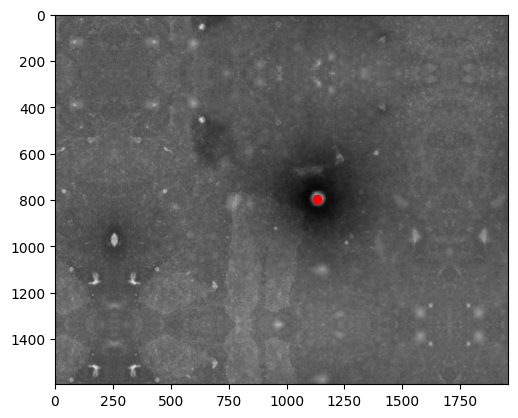

In [114]:
plt.imshow(padded_scaled_resized_img, cmap="gray")
plt.scatter(x = [p[0]+IMAGE_SIZE for p in particles], y = [p[1]+IMAGE_SIZE for p in particles], c='r')

### Crop around particle positions

1. For each particle position, crop around it (don't forget to add imagesize to coordinates!)
2. Check how many particles fall out of the loop if we don't have padding

In [115]:
imagettes = []

for p in particles:
    offset_height = round(p[1]+IMAGE_SIZE - IMAGE_SIZE/2)
    offset_width = round(p[0]+IMAGE_SIZE - IMAGE_SIZE/2)
    imagettes.append(tf.image.crop_to_bounding_box(padded_scaled_resized_img, 
                              offset_height=offset_height,
                              offset_width=offset_width,
                              target_height=IMAGE_SIZE,
                              target_width=IMAGE_SIZE))

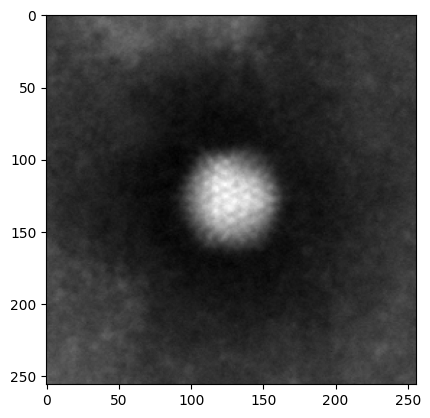

In [116]:
plt.imshow(imagettes[0],cmap="gray")

### Save as .tif

In [127]:
cv2.imwrite('test.tif', imagettes[0].numpy())

True